# Example 1: Training a model
---

The following code downloads the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), defines a model with one hidden linear layer, and trains the model by backpropagation, trying to minimize the cross-entropy loss between predictions and actual targets. Model parameters trained with PyTorch can also be [saved and loaded](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [1]:
# Training a model on MNIST:

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torchvision import datasets, transforms # Define dataset 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform) 

testset = datasets.MNIST('./data', download=True, train=False, transform=transform) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) 
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True) 


# Define model architecture 
class Net(nn.Module):
    def __init__(self,n=16):
        super().__init__()
        self.hidden_layer = nn.Linear(784,n)
        self.flatten = nn.Flatten()
        self.finale_layer = nn.Linear(n,10)
        
    def forward(self,x):
        x = self.flatten(x)
        x = self.hidden_layer(x)
        x = self.finale_layer(x)
        return x
n = 16
model = Net(n)
# Define loss and optimizer 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

def evaluate(model,testloader):
    # Test the model 
    correct = 0 
    total = 0 
    with torch.no_grad(): 
        for data in testloader: 
            images, labels = data 
            outputs = model(images) 
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item() 
    return 100 * correct / total

# Train the model 
print("Training the Model:")
for epoch in range(10): 
    running_loss = 0.0 
    for i, data in enumerate(trainloader): 
        inputs, labels = data 
        optimizer.zero_grad() 
        # Forward pass 
        outputs = model(inputs) 
        loss = criterion(outputs, labels) # Backward pass and optimize 
        loss.backward() 
        optimizer.step() 
        running_loss += loss.item() 
    print(f'├─ Epoch {epoch+1} loss: {running_loss/len(trainloader)} (Acc.: {evaluate(model,testloader)} %)') 


print(f'╰─[Accuracy of the model on the test images: {evaluate(model,testloader)} %]')

Training the Model:
├─ Epoch 1 loss: 0.4666622360663882 (Acc.: 89.94 %)
├─ Epoch 2 loss: 0.3218271486969518 (Acc.: 91.88 %)
├─ Epoch 3 loss: 0.30826860031228204 (Acc.: 91.37 %)
├─ Epoch 4 loss: 0.2980275931976624 (Acc.: 91.96 %)
├─ Epoch 5 loss: 0.2953033606682632 (Acc.: 91.42 %)
├─ Epoch 6 loss: 0.2896105055290181 (Acc.: 91.98 %)
├─ Epoch 7 loss: 0.2851992215214571 (Acc.: 92.24 %)
├─ Epoch 8 loss: 0.28412325082938555 (Acc.: 92.03 %)
├─ Epoch 9 loss: 0.2822391664200246 (Acc.: 92.03 %)
├─ Epoch 10 loss: 0.27964433567769237 (Acc.: 91.91 %)
╰─[Accuracy of the model on the test images: 91.91 %]


# Example 2: Computing a heatmap explanation with CRP

---

The following code computes the explanation of the network prediction in form of a heatmap. <br>
You can use/adapt it for you backend-logic. Interactions with your web-app should change the parameters 
- `idx` - which changes the input of the neural network
- `hidden_neuron_idx` - index of the hidden neuron (which concept) we condition the explanation on (see CRP)
- `output_neuron_idx` - index of the output neuron (which output-class) we condition the explanation on

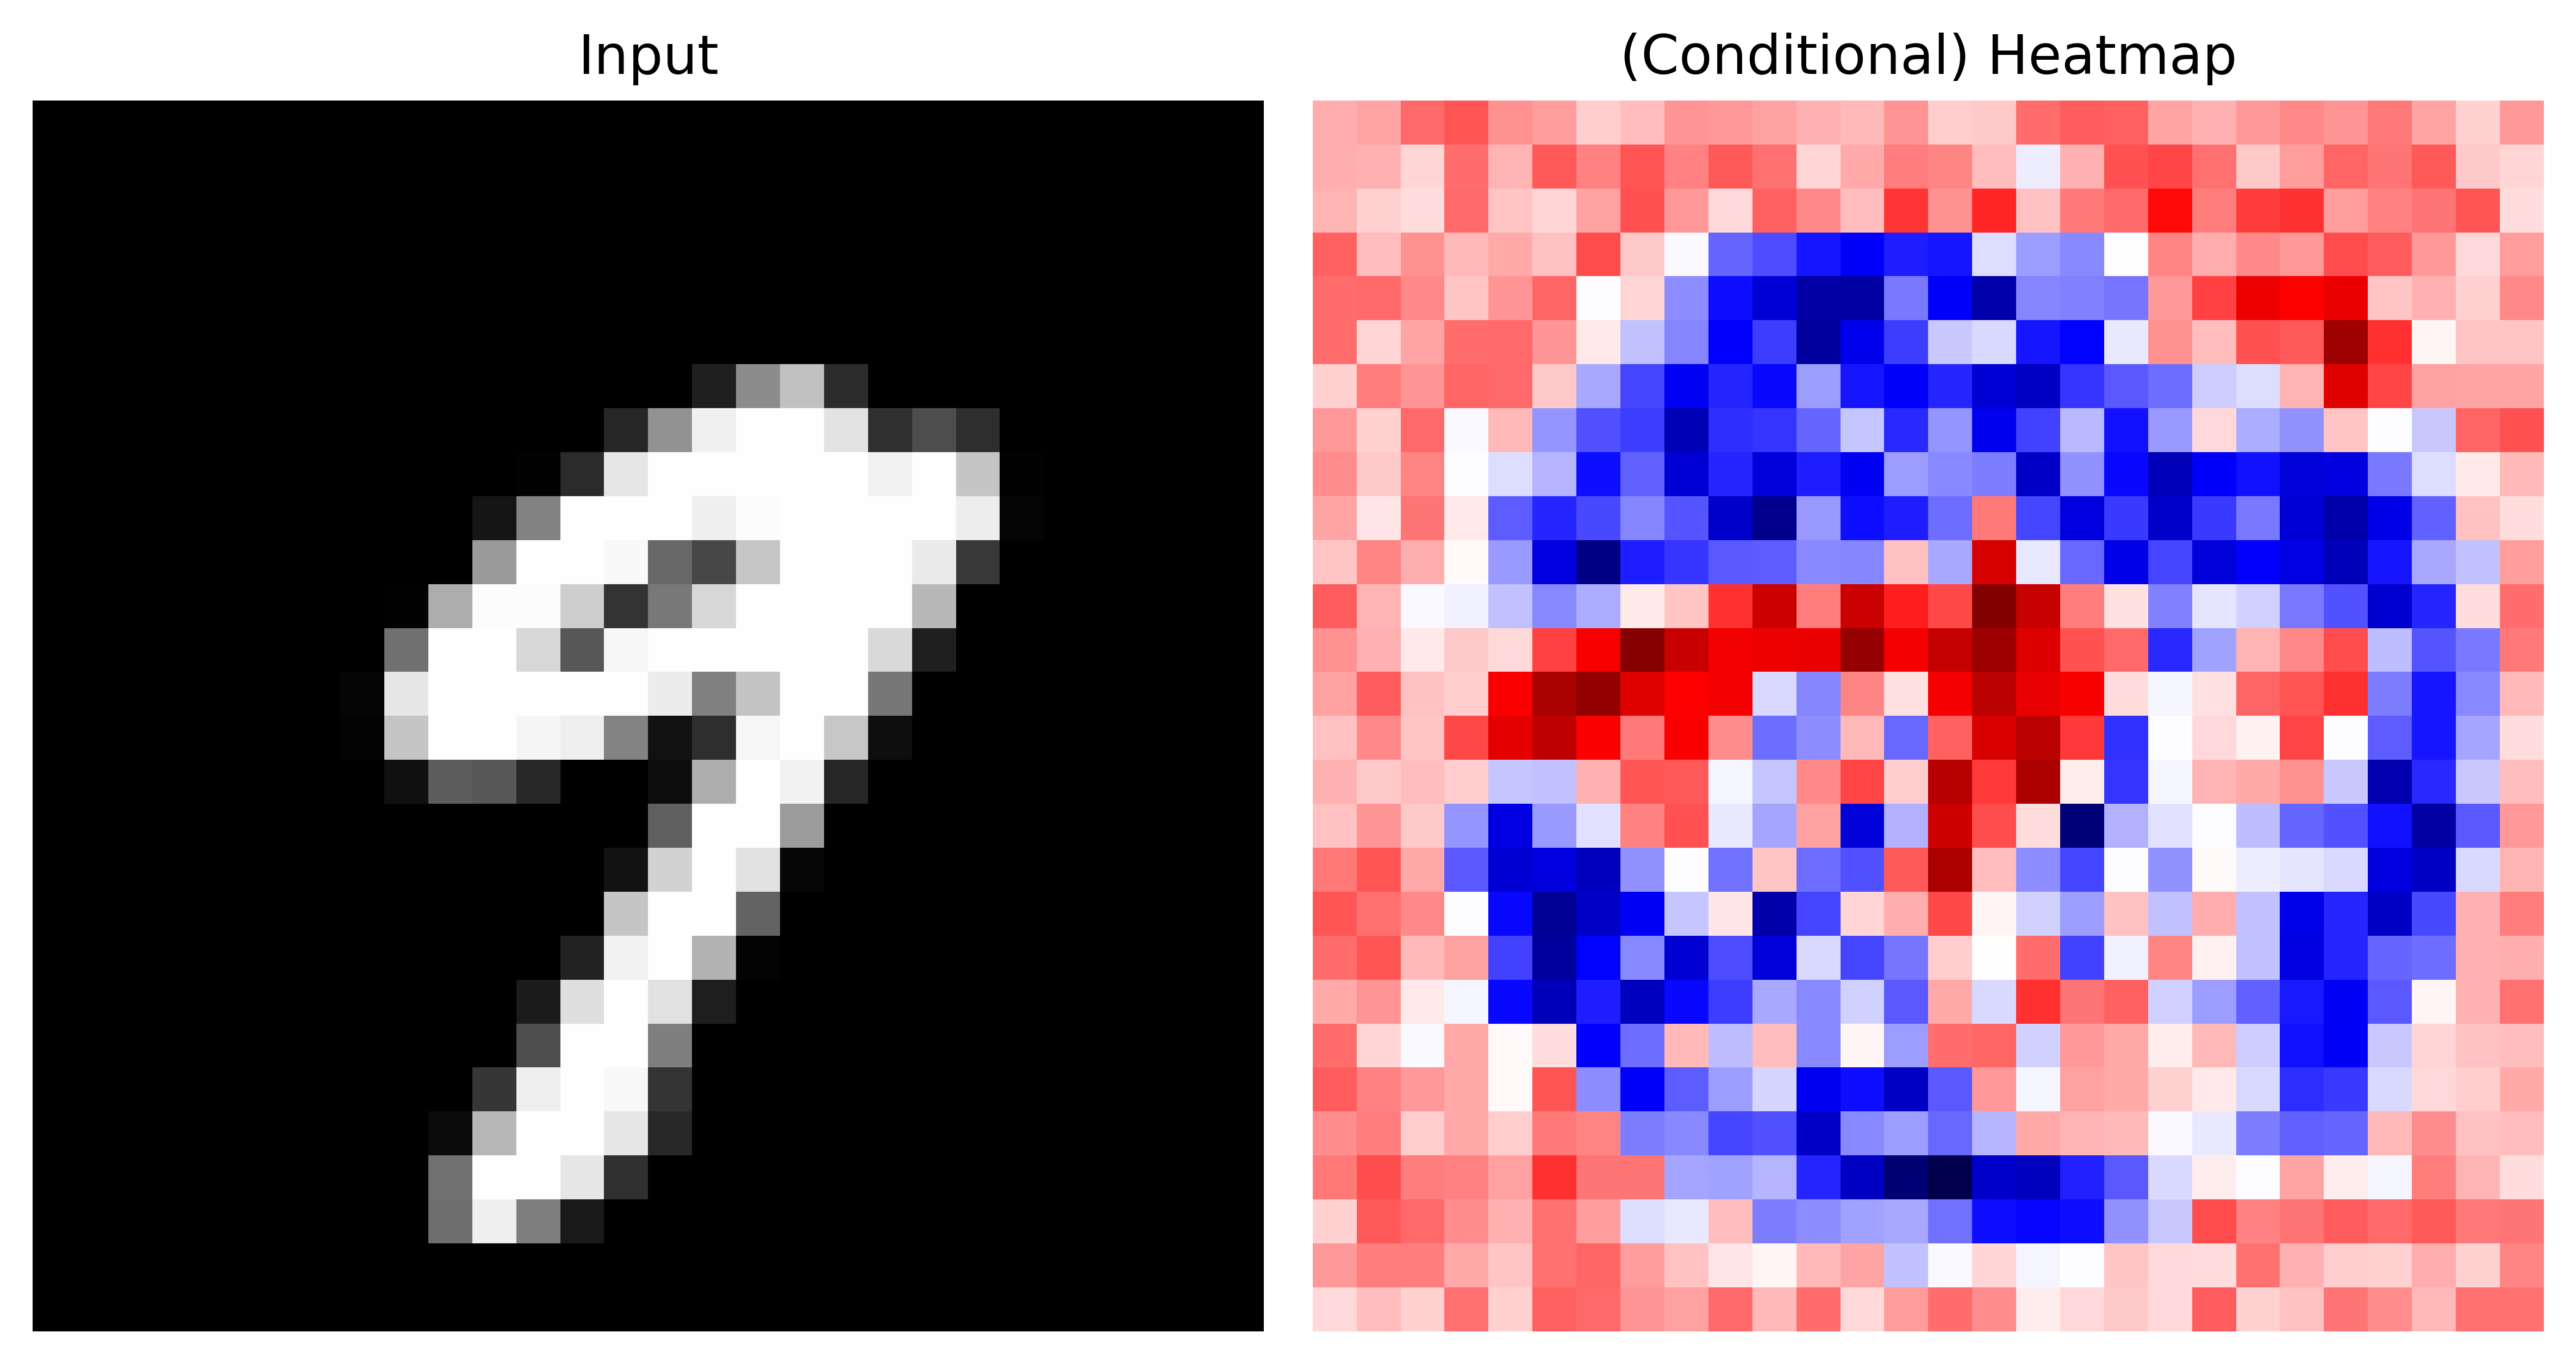

In [3]:
# Computing CRP heatmap explanations:

# modules used for visualizing the images
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# modules for computing the explanations
from zennit.composites import EpsilonPlus
from crp.attribution import CondAttribution


vis_testset = datasets.MNIST('./data', 
                             download=True, 
                             train=False, 
                             transform=transforms.Compose([transforms.ToTensor()])) 
# ╰─ Visualization-Dataset without normalization applied.


# ··········· PARAMETERS ·············
# PLAY AROUND WITH THOSE VALUES TO SEE
# HOW THE EXPLANATIONS CHANGE. THESE 
# PARAMETERS HAVE TO BE INTERACTIVELY
# ADJUSTED BY THE USER IN YOUR DEMO.
idx = 20                               # index of the data sample in the dataset
hidden_neuron_idx = 8 # 0-15 or None    # index of the hidden neuron (which concept) we condition the explanation on
output_neuron_idx = 7 # 0-9             # index of the output neuron (which output-class) we condition the explanation on
# ····································


# There are several different rules to compute relevances.
# Here we initialize the explainer with our model and the LRP-rule,
# and set the conditions for the explanation based on the above values.
attributor = CondAttribution(model, EpsilonPlus()) 
conditions=[{
    'y':output_neuron_idx,
    'hidden_layer':hidden_neuron_idx
}]

# load and init sample 
sample = testset[idx][0]        # transformed test-data is used
sample = sample.unsqueeze(0)    
sample.requires_grad_()         # for the heatmap computation the data requires gradients

# Compute the explanation:
attribution = attributor(sample,conditions=conditions)
heatmap = attribution.heatmap # THIS IS THE HEATMAP YOU NEED TO SHOW


# Visualizing samples side-by-side, just for illustration purposes:
vis_heatmap = heatmap.permute(1,2,0)
viz_sample = vis_testset[idx][0].permute(1,2,0)

fig, axes = plt.subplots(1,2,dpi=600,figsize=(8,5))
v = max(abs(heatmap.max().item()), abs(heatmap.min().item()))

axes[0].imshow(viz_sample, cmap='gray')
axes[1].imshow(vis_heatmap, cmap='seismic',norm=Normalize(vmin=-v,vmax=v))

axes[0].set_title("Input")
axes[1].set_title("(Conditional) Heatmap")
axes[0].axis('off')
axes[1].axis('off')
fig.tight_layout()
plt.show()